## Fixed parameter search

This notebook is intendend to find the best matching values for fixed parameters to be used in the simulation.

These parameters include:
- Distribution of time between orders.
    - Probably exponential distribution, extension of Poisson dist
- Distribution of token size of trades
    - Possibly different for buy and sell orders
- Buy or Sell order
    - Some function of past X trades completed. This is undecided yet.

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import kstest, expon
from scipy.stats import halfgennorm, pareto, exponnorm, lognorm
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pair_list = [
            ("AGIX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0xe45b4a84e0ad24b8617a489d743c52b84b7acebe", 40),
            ("HEX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x55d5c232d921b9eaa6b37b5845e439acd04b4dba", 100),
            ("OPTIMUS-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x8de7a9540e0edb617d78ca5a7c6cc18295fd8bb9", 70),
            ("SHIB-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x811beed0119b4afce20d2583eb608c6f7af1954f", 50),
            ("SHIK-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x0b9f5cef1ee41f8cccaa8c3b4c922ab406c980cc", 60),
            ("BabyDoge-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0xc736ca3d9b1e90af4230bd8f9626528b3d4e0ee0", 180),
            ("FLOKI-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x231d9e7181e8479a8b40930961e93e7ed798542c", 180),
            ("INJ-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x1bdcebca3b93af70b58c41272aea2231754b23ca", 60),
            ("MBOX-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x8fa59693458289914db0097f5f366d771b7a7c3f", 90),
            ("VOLT-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x487bfe79c55ac32785c66774b597699e092d0cd9", 200)
            ]

In [3]:
def load_csv_to_df(file_path, verbose=False, name=""):
    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # If verbose mode is enabled, print the dataset name, number of rows, and some datetime information
    if verbose:
        #print(name)
        print("Number of rows:", len(df))
        print("Last datetime:", df.datetime.iloc[-2], )  # Assuming there is a "datetime" column in the DataFrame
        print("First datetime:", df.datetime.iloc[0])
        print("Time difference (in days):", datetime.strptime(df.datetime.iloc[0], '%Y-%m-%d %H:%M:%S') - datetime.strptime(df.datetime.iloc[-5], '%Y-%m-%d %H:%M:%S'))
        print()
    
    # Return the DataFrame
    return df

def set_index(df, info=False):
    # Convert 'datetime' column to datetime type and set it as the index
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    if info:
        # Print some information about the resulting DataFrame
        df.info()

In [4]:
##Part 1 - The time spacing
table_dists = []
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)


    #compute the spacing between variables
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1

    #Cropping data to 99th percentile
    percentile_99 = np.percentile(spacing, 99)
    spacing_99 = [val for val in spacing if val <= percentile_99]

    basic_expon = False
    if basic_expon:
        param = expon.fit(spacing_99)
        print(param)

        statistic, p_value = kstest(spacing_99, 'expon', args=param)

        # Print the p-value
        print("The p-value is:", p_value)

    fitter_dist_fitting = True
    if fitter_dist_fitting:
        #dists = get_common_distributions()
        #dists.append('exponweib')
        #dists = get_distributions()
        # dists = ['gamma',
        #         'lognorm',
        #         "beta",
        #         "burr",
        #         "norm",
        #         "expon", 
        #         "exponnorm", 
        #         "exponpow",
        #          "exponweib",
        #          "truncexpon",
        #          "pareto",
        #          "cauchy",
        #          "gumbel_r",
        #          "laplace"]

        ###Candidate distributions selected based on running all dists on several tokens
        # d = get_common_distributions()
        # d.extend(['johnsonsb', 'fatiguelife', 'exponweib', 'gengamma', 'halfgennorm'])
        # d.extend(['pareto', 'expon', 'halflogistic', 'cauchy', 'moyal'])
        # d.extend(['fatiguelife', 'exponweib', 'gengamma', 'halfgennorm', 'lognorm'])
        # d.extend(['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'])
        # d.extend(['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'])
        # d.extend(['pareto', 'expon', 'cauchy', 'moyal', 'gumbel_r'])
        # d.extend(['f', 'kappa3', 'alpha', 'beta', 'bradford'])
        # d.extend(['expon', 'cauchy', 'laplace', 'gumbel_r', 'logistic'])
        # dists = list(set(d))

        #dists = ['halfgennorm']
        #dists = ['pareto']
        dists = ['expon']

        f = Fitter(spacing_99,
           distributions=dists)
        f.fit()
        
        try:
            print(f.get_best())     #here I end up. The goal is to estimate distributions from which draw times. 
                                    #heaving three is a good way I think. One of them will be halfgennorm with beta = 0.4
                                    #What to do next: check that the selected first dist will be ok if I set parameter beta fixed to 0.4, plot i histograms as random sample. Do the same for pareto. end expon                               
        except:
            pass                                    
        # print(f.summary())
        # plt.show()

        Nbest = 5
        ###Try to get x best dists
        names = f.df_errors.sort_values(
                    by="bic").index[0:Nbest].values
        
        #print(names)
        
        
    
        do_dist_table = False
        if do_dist_table:
            row = [name[:-5]]
            for element in dists:
                if element in names:
                    row.append(1)
                else:
                    row.append(" ")
            table_dists.append(row)
            #print(names)

        

        ##lets try three runs on the first token
        #run 1: ['johnsonsb', 'fatiguelife', 'exponweib', 'gengamma', 'halfgennorm'] (not restarted)
        #run 2: ['pareto', 'expon', 'halflogistic', 'cauchy', 'moyal'] (restarted)
        #run 3: ['fatiguelife', 'exponweib', 'gengamma', 'halfgennorm', 'lognorm'] (not restarted)
        #run 4: ['fatiguelife' 'exponweib' 'gengamma' 'halfgennorm' 'levy'] (restarted + bic selection)

        ##Two runs on OPTIMUS
        #run 1: ['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'] (restarted)
        #run 2: ['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'] (restarted)
        #run 3: ['pareto', 'expon', 'cauchy', 'moyal', 'gumbel_r'] (not restarted)

        ##Two runs at FLOKI
        #run 1: ['f', 'kappa3', 'alpha', 'beta', 'bradford'] (restarted)
        #run 2: ['expon', 'cauchy', 'laplace', 'gumbel_r', 'logistic'] (not restarted)

if do_dist_table:        
    table_dists = pd.DataFrame(table_dists)
    #table_dists.set_index(table_dists.iloc[:, 0], inplace=True)
    #table_dists.columns = ["Token"].extend(dists)
    colnames = list(["Token"])
    colnames.extend(dists)
    table_dists.columns = colnames
    #print(table_dists)
    #table_dists.to_csv(r"D:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Tables\Timing_distributions_scores.csv", index=False)


    #once at home, try to run on all distributions, and set the max names to 10
    

~~~---AGIX-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 66.86it/s]


{'expon': {'loc': 0.0, 'scale': 398.22149302707135}}
~~~---HEX-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 42.08it/s]


{'expon': {'loc': 0.0, 'scale': 95.83093899646055}}
~~~---OPTIMUS-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 52.37it/s]


{'expon': {'loc': 0.0, 'scale': 153.3993220338983}}
~~~---SHIB-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 75.55it/s]


{'expon': {'loc': 0.0, 'scale': 306.1414913957935}}
~~~---SHIK-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 84.54it/s]


{'expon': {'loc': 0.0, 'scale': 335.943754394188}}
~~~---BabyDoge-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 29.74it/s]

{'expon': {'loc': 0.0, 'scale': 68.75762721148052}}
~~~---FLOKI-WBNB---~~~



Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 92.91it/s]


{'expon': {'loc': 0.0, 'scale': 44.877010877891834}}
~~~---INJ-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 125.35it/s]


{'expon': {'loc': 0.0, 'scale': 185.54828744123571}}
~~~---MBOX-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 119.33it/s]


{'expon': {'loc': 0.0, 'scale': 103.46294594368786}}
~~~---VOLT-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 103.76it/s]

{'expon': {'loc': 0.0, 'scale': 60.60467855940761}}


In [5]:
%%script false
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)


    #compute the spacing between variables
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1

    #Cropping data to 99th percentile
    percentile_99 = np.percentile(spacing, 99)
    spacing_99 = [val for val in spacing if val <= percentile_99]


    #Try to compare data with random sample from the fitted distributions
    #r = halfgennorm.rvs(beta = 0.4, loc=0, scale=4, size=5000)#This is how to draw random sample from halfgennorm - this will be my setting number one, it fits many distributions well (only first parameter decides about shape of dist., seconf is always 0 and third about size)
    #r = pareto.rvs(b = 2.5, loc=-80, scale=80, size=5000) #This I guess will by my second distribution
    r = expon.rvs(loc = 0, scale=300, size = 5000) #And this could be the third one
    #
    #{'pareto': {'b': 6.793733998573082, 'loc': -400.09425046951173, 'scale': 400.0942504695117}
    #{'expon': {'loc': 0.0, 'scale': 306.1414913957935}}
    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    axes[0].hist(spacing, bins=100, color='blue', edgecolor='black')
    axes[0].set_title(f'{name} Histogram of Spacing between Observations')

    axes[1].hist(r, bins=100, color='red', edgecolor='black')
    axes[1].set_title('Random sample')
    
    #plt.hist(spacing_99, bins=100, edgecolor='black')
    plt.show()

Couldn't find program: 'false'


~~~---AGIX-WETH---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00, 11.66it/s]


{'lognorm': {'s': 1.7486228235070342, 'loc': -4.119400759106176, 'scale': 886.6765460384474}}
           sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm       1.414412e-08  2972.822095 -97112.113184     inf      0.157628   
exponnorm     2.233211e-08  6278.200895 -95424.508147     inf      0.204793   
expon         2.244664e-08  6257.222706 -95413.820625     inf      0.205842   

               ks_pvalue  
lognorm     1.175776e-80  
exponnorm  2.295614e-136  
expon      8.951296e-138  


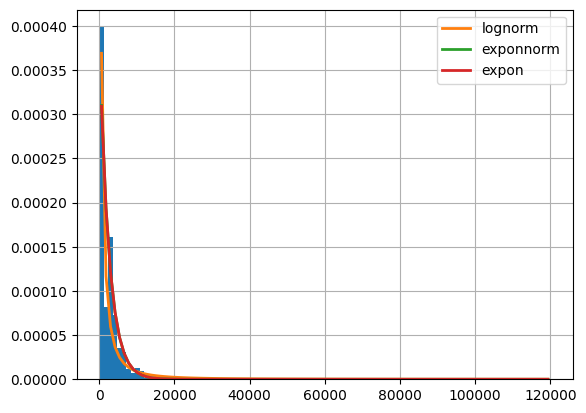

~~~---HEX-WETH---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


{'expon': {'loc': 5.71e-07, 'scale': 9496.554651608914}}
           sumsquare_error           aic            bic  kl_div  ks_statistic  \
expon         5.685016e-11  23344.442657 -482554.176154     inf      0.270953   
exponnorm     5.726108e-11  23380.547689 -482439.827504     inf      0.270090   
lognorm       6.775732e-10   4294.423986 -446498.167906     inf      0.018710   

           ks_pvalue  
expon       0.000000  
exponnorm   0.000000  
lognorm     0.000075  


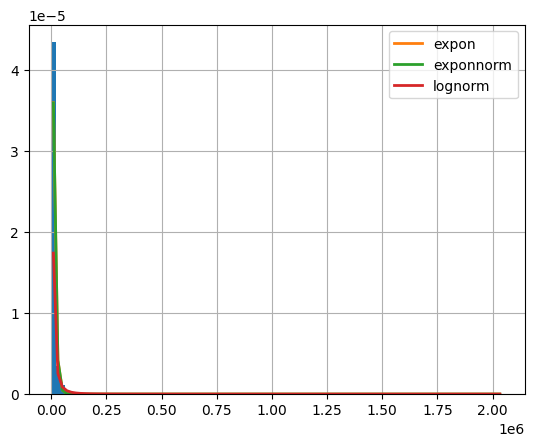

~~~---OPTIMUS-WETH---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


{'lognorm': {'s': 1.7793370589022515, 'loc': -11.764789221063017, 'scale': 977.6967898020146}}
           sumsquare_error          aic            bic  kl_div  ks_statistic  \
lognorm       6.321901e-09  3010.267105 -250120.861275     inf      0.073580   
exponnorm     1.952430e-08  6105.904269 -240038.631312     inf      0.184361   
expon         1.978541e-08  6080.223849 -239928.948308     inf      0.186087   

               ks_pvalue  
lognorm     1.529377e-42  
exponnorm  1.826506e-266  
expon      1.653458e-271  


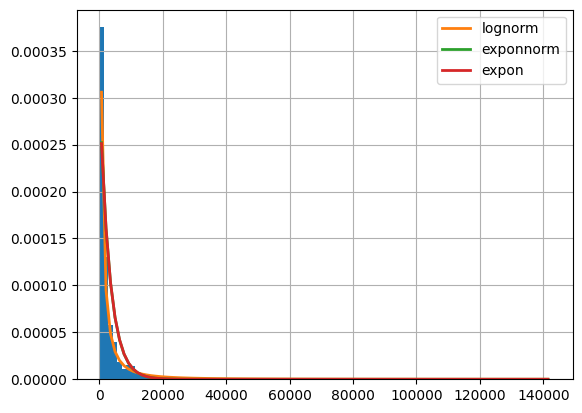

~~~---SHIB-WETH---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]


{'exponnorm': {'K': 2322.0693697820316, 'loc': -31616.040401452046, 'scale': 16035.754287929012}}
           sumsquare_error           aic            bic  kl_div  ks_statistic  \
exponnorm     1.459834e-17  16645.148144 -224613.729430     inf      0.330544   
expon         1.474818e-17  16585.424501 -224573.629745     inf      0.332176   
lognorm       1.168661e-16   5307.326205 -214720.673684     inf      0.065469   

              ks_pvalue  
exponnorm  0.000000e+00  
expon      0.000000e+00  
lognorm    3.626789e-18  


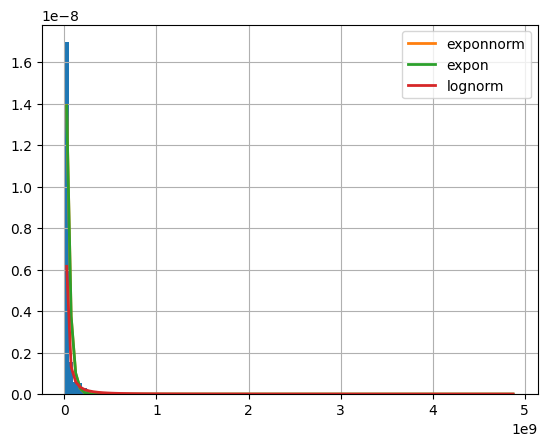

~~~---SHIK-WETH---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


{'lognorm': {'s': 1.5037133388610298, 'loc': -2056319550.447643, 'scale': 122432990872.83214}}
           sumsquare_error          aic            bic  kl_div  ks_statistic  \
lognorm       4.873973e-25  6308.965774 -277451.553574     inf      0.045960   
exponnorm     8.914977e-24  7007.098219 -264919.120964     inf      0.153138   
expon         9.023407e-24  6993.639839 -264875.361008     inf      0.155447   

              ks_pvalue  
lognorm    2.361205e-08  
exponnorm  9.197619e-89  
expon      1.846998e-91  


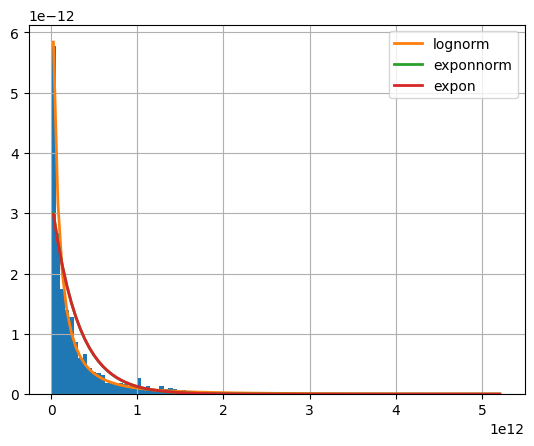

~~~---BabyDoge-WBNB---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


{'lognorm': {'s': 1.8123158713214913, 'loc': -53863055.7409897, 'scale': 12193202730.804386}}
           sumsquare_error            aic           bic  kl_div  ks_statistic  \
lognorm       5.586824e-25    8709.125312 -1.211061e+06     inf      0.020848   
exponnorm     5.711293e-25  124690.112295 -1.210654e+06     inf      0.462859   
expon         5.713400e-25  124848.935340 -1.210657e+06     inf      0.463286   

              ks_pvalue  
lognorm    2.146183e-07  
exponnorm  0.000000e+00  
expon      0.000000e+00  


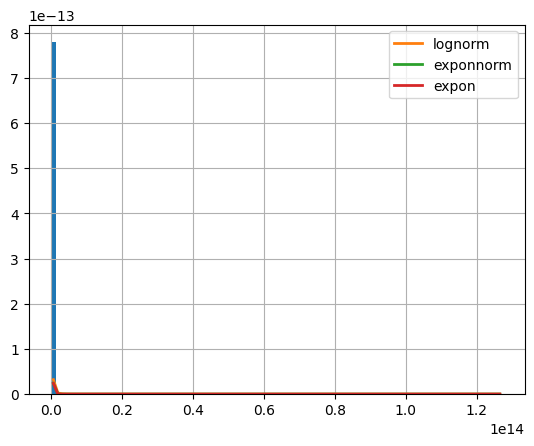

~~~---FLOKI-WBNB---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


{'expon': {'loc': 0.0022, 'scale': 10293084.217959348}}
           sumsquare_error           aic           bic  kl_div  ks_statistic  \
expon         6.199401e-17  30463.265222 -1.252395e+06     inf      0.467798   
exponnorm     6.234647e-17  30432.788866 -1.252236e+06     inf      0.466754   
lognorm       7.560900e-16   5218.150898 -1.186438e+06     inf      0.054361   

              ks_pvalue  
expon      0.000000e+00  
exponnorm  0.000000e+00  
lognorm    3.645746e-68  


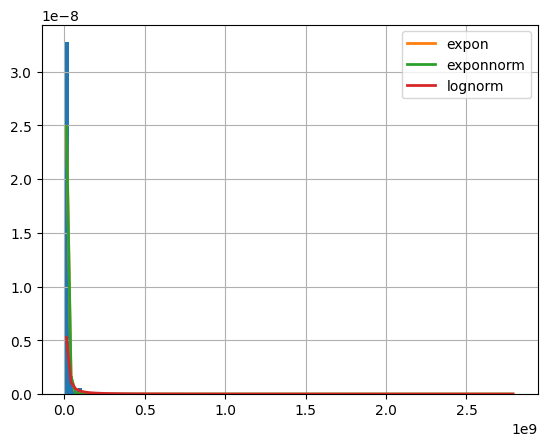

~~~---INJ-WBNB---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00, 11.23it/s]


{'exponnorm': {'K': 3.744524574097655, 'loc': 9.863199833008139, 'scale': 12.446438099485768}}
           sumsquare_error          aic            bic  kl_div  ks_statistic  \
exponnorm         0.000091  6286.623339 -137079.561918     inf      0.160973   
lognorm           0.000136  3203.250436 -134098.886603     inf      0.164544   
expon             0.000172  5400.124084 -132322.393112     inf      0.174948   

               ks_pvalue  
exponnorm  9.366984e-171  
lognorm    1.930260e-178  
expon      7.974365e-202  


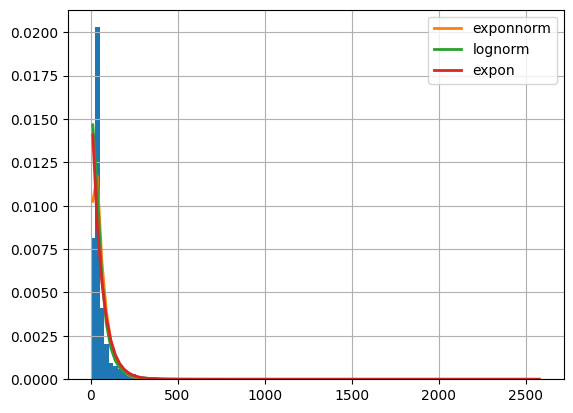

~~~---MBOX-WBNB---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


{'exponnorm': {'K': 2447.3538046608846, 'loc': -1.0070808761605645, 'scale': 0.64265918522034}}
           sumsquare_error           aic            bic  kl_div  ks_statistic  \
exponnorm     3.765399e-09  11373.444115 -348163.927183     inf      0.266877   
expon         3.912639e-09  11312.357328 -347709.538447     inf      0.267922   
lognorm       5.798249e-08   3102.984469 -315103.659988     inf      0.121799   

               ks_pvalue  
exponnorm   0.000000e+00  
expon       0.000000e+00  
lognorm    8.953869e-157  


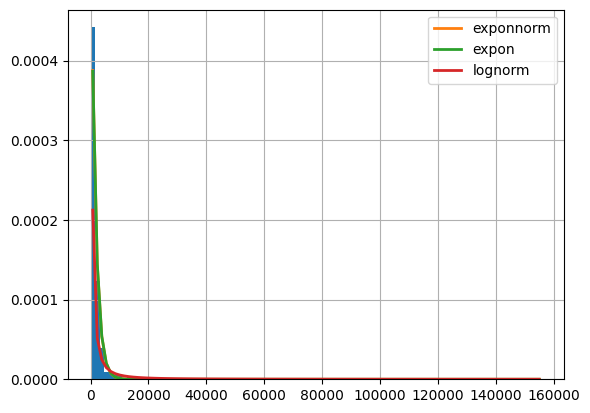

~~~---VOLT-WBNB---~~~


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


{'exponnorm': {'K': 0.6724023248251942, 'loc': 408637483.63543415, 'scale': 293053981.202839}}
           sumsquare_error           aic            bic  kl_div  ks_statistic  \
exponnorm     1.894513e-20  20200.177282 -994215.904812     inf      0.049526   
expon         8.225145e-19   9577.488246 -926320.787051     inf      0.225108   
lognorm       2.317103e-18   5542.970098 -907659.982090     inf      0.731693   

              ks_pvalue  
exponnorm  7.952703e-39  
expon      0.000000e+00  
lognorm    0.000000e+00  


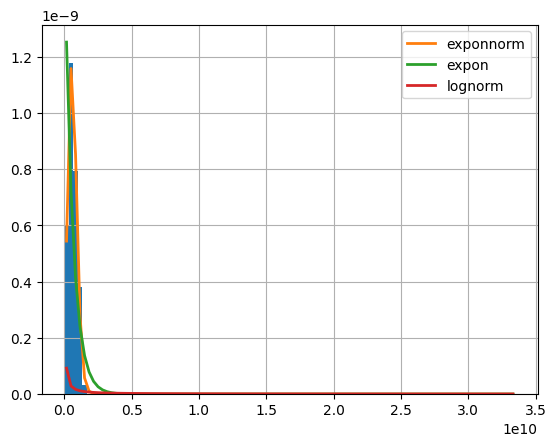

In [11]:
###Part 2 - distribution of order size
table_dists = []
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    log_amount_token = np.log10(df.amount_token)
    log_total_native = np.log10(df.total_native)

    ##Distribution fitting
    #dists = get_common_distributions()
    #dists = get_distributions()
    ###Candidate distributions selected based on running all dists on all tokens
    # d = get_common_distributions()
    # d.extend(['halfgennorm', 'burr12', 'pareto', 'genpareto', 'fisk'])
    # d.extend(['halflogistic', 'gumbel_r', 'genlogistic', 'moyal', 'expon'])
    # d.extend(['halfcauchy', 'foldcauchy', 'genpareto', 'pareto', 'invgamma'])
    # d.extend(['exponnorm', 'expon', 'genexpon', 'moyal', 'halflogistic'])
    # d.extend(['pareto', 'expon', 'cauchy', 'powerlaw', 'laplace'])

    # d.extend(['halfnorm', 'foldnorm', 'rayleigh', 'maxwell', 'kstwobign'])
    # d.extend(['halflogistic', 'expon', 'laplace_asymmetric', 'exponnorm', 'gumbel_r'])
    # d.extend(['dgamma', 'dweibull', 'foldcauchy', 'laplace', 'cauchy'])
    # d.extend(['gilbrat', 'gibrat', 'exponnorm', 'expon', 'laplace_asymmetric'])
    # d.extend(['exponnorm', 'genlogistic', 'beta', 'betaprime', 'maxwell'])
    # dists = list(set(d))

    dists = ['expon', 'exponnorm', 'lognorm']

    f = Fitter(df.amount_token,
           distributions=dists)
    f.fit()
    try:
        print(f.get_best())     
    except:
        pass                                    
    print(f.summary())
    plt.show()

    Nbest = 5
    #Get names of x best dists
    names = f.df_errors.sort_values(
                by="bic").index[0:Nbest].values
        
    #print(names)

       
    do_dist_table = False
    if do_dist_table:
        row = [name[:-5]]
        for element in dists:
            if element in names:
                row.append(1)
            else:
                row.append(" ")
        table_dists.append(row)
    ##AGIX
    #['halfgennorm' 'burr12' 'pareto' 'genpareto' 'fisk']
    ##HEX
    #['halflogistic' 'gumbel_r' 'genlogistic' 'moyal' 'expon']
    #OPTIMUS
    #['halfcauchy' 'foldcauchy' 'genpareto' 'pareto' 'invgamma']
    ##SHIB
    #['exponnorm' 'expon' 'genexpon' 'moyal' 'halflogistic']
    ##SHIK
    #['pareto' 'expon' 'cauchy' 'powerlaw' 'laplace']
    ##BabyDoge
    #['halfnorm' 'foldnorm' 'rayleigh' 'maxwell' 'kstwobign']
    ##FLOKI
    #['halflogistic' 'expon' 'laplace_asymmetric' 'exponnorm' 'gumbel_r']
    ##INJ
    #['dgamma' 'dweibull' 'foldcauchy' 'laplace' 'cauchy']
    ##MBOX
    #['gilbrat' 'gibrat' 'exponnorm' 'expon' 'laplace_asymmetric']
    ##VOLT
    #['exponnorm' 'genlogistic' 'beta' 'betaprime' 'maxwell']




if do_dist_table:        
    table_dists = pd.DataFrame(table_dists)
    #table_dists.set_index(table_dists.iloc[:, 0], inplace=True)
    #table_dists.columns = ["Token"].extend(dists)
    colnames = list(["Token"])
    colnames.extend(dists)
    table_dists.columns = colnames
    print(table_dists)
    #table_dists.to_csv(r"D:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Tables\Simulation_Swaps_distributions_scores.csv", index=False)
    #So I have three candidates: expon(does not fit theoretically but ok) exponnorm, lognorm



~~~---AGIX-WETH---~~~


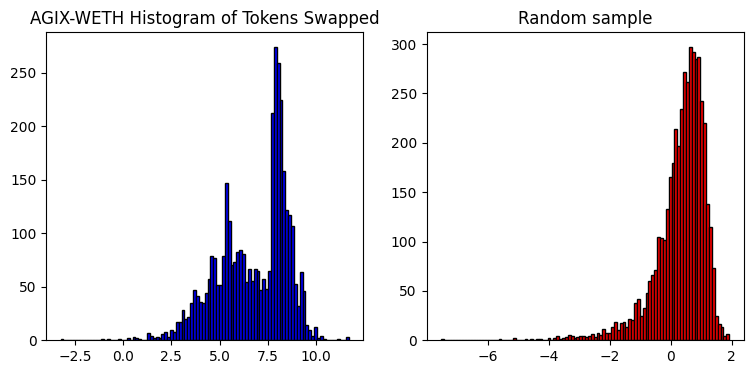

~~~---HEX-WETH---~~~


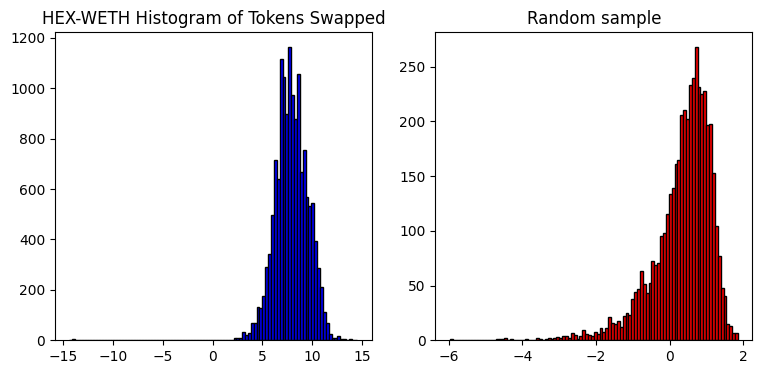

~~~---OPTIMUS-WETH---~~~


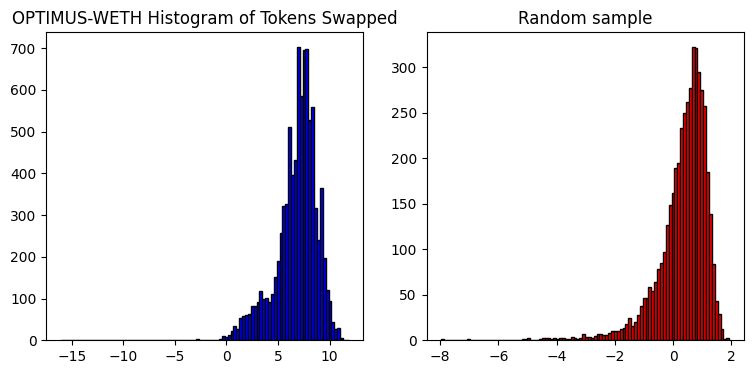

~~~---SHIB-WETH---~~~


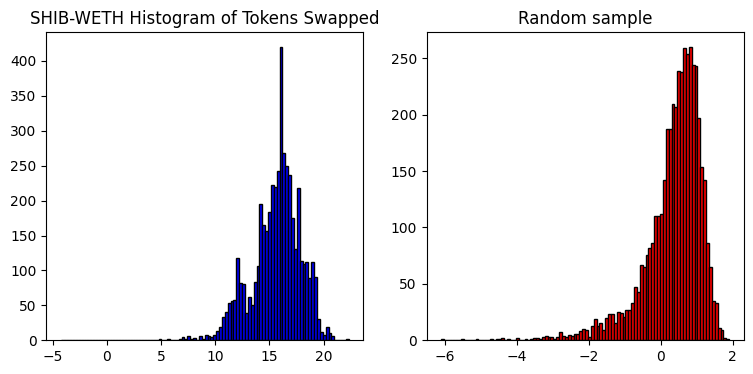

~~~---SHIK-WETH---~~~


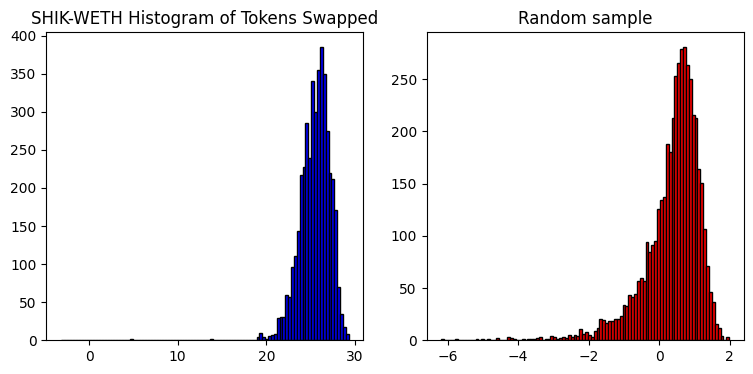

~~~---BabyDoge-WBNB---~~~


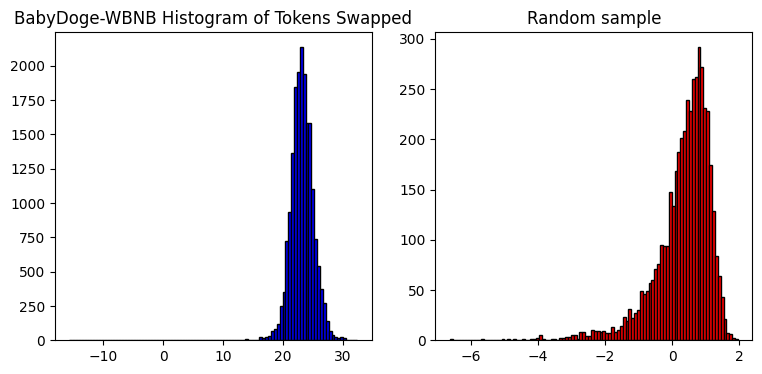

~~~---FLOKI-WBNB---~~~


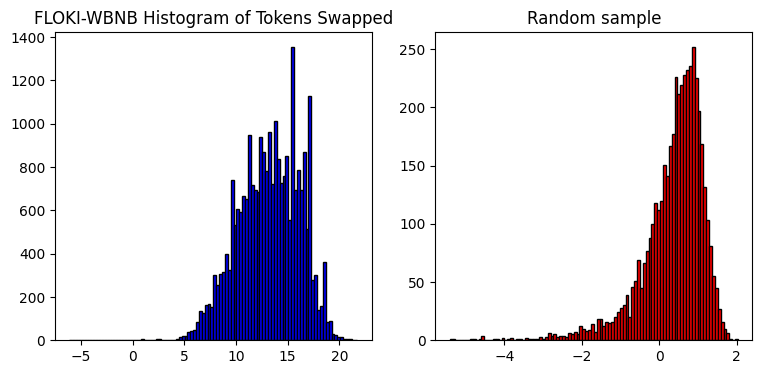

~~~---INJ-WBNB---~~~


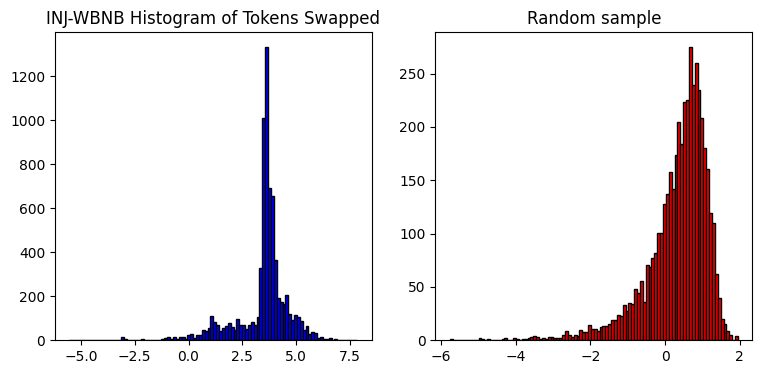

~~~---MBOX-WBNB---~~~


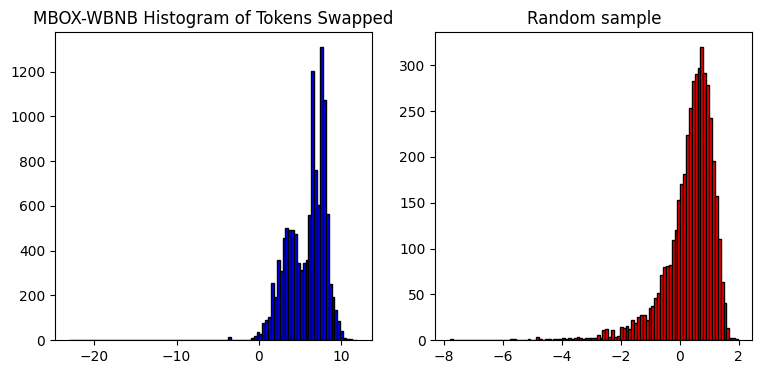

~~~---VOLT-WBNB---~~~


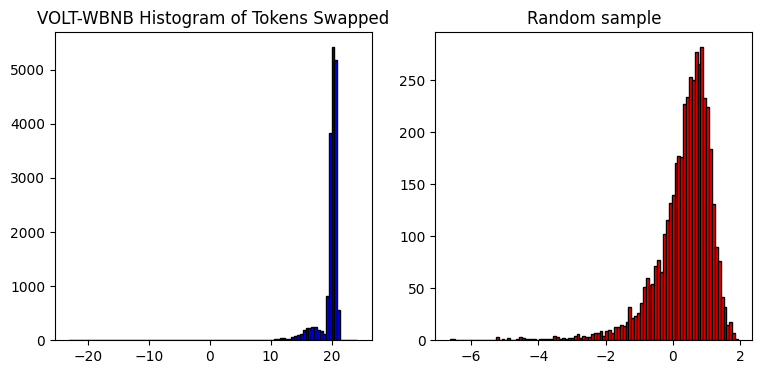

In [25]:
#Plotting candidates for the swap distributions
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)



    #Try to compare data with random sample from the fitted distributions
    #r = halfgennorm.rvs(beta = 0.4, loc=0, scale=4, size=5000)#This is how to draw random sample from halfgennorm - this will be my setting number one, it fits many distributions well (only first parameter decides about shape of dist., seconf is always 0 and third about size)
    #r = pareto.rvs(b = 2.5, loc=-80, scale=80, size=5000) #This I guess will by my second distribution
    r = exponnorm.rvs(K = 0.6, loc = 1, scale=1, size = 5000) #And this could be the third one
    #{'exponnorm': {'K': 0.6724023248251942, 'loc': 408637483.63543415, 'scale': 293053981.202839}}
    #{'lognorm': {'s': 1.7486228235070342, 'loc': -4.119400759106176, 'scale': 886.6765460384474}}
    #{'expon': {'loc': 0.0022, 'scale': 10293084.217959348}}


    #Continue here, find specifications of distributions that would seem good. 
    #Think about possibility of cutting values bellow zero (not transformed to log). Is log transform good approach??
    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    axes[0].hist(np.log(df.amount_token), bins=100, color='blue', edgecolor='black')
    axes[0].set_title(f'{name} Histogram of Tokens Swapped')

    axes[1].hist(np.log(r), bins=100, color='red', edgecolor='black')
    axes[1].set_title('Random sample')
    
    #plt.hist(spacing_99, bins=100, edgecolor='black')
    plt.show()

In [7]:
%%script false
#explore distribution of buy/sell order sizes separately
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    data_buy = df[df['buy_order'] == True]
    data_sell = df[df['buy_order'] == False]

    # data = data_buy.total_native
    # data = data_sell.amount_token

    log_amount_token_b = np.log10(data_buy.amount_token)
    log_amount_token_s = np.log10(data_sell.amount_token)

    # Define the logarithmically spaced bins
    bins = np.logspace(np.log10(data_buy.amount_token.min()), np.log10(data_buy.amount_token.max()), 100)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    axes[0].hist(log_amount_token_b, bins=bins, color='blue', edgecolor='black')
    axes[0].set_title(f'{name} Native Tokens swapped_BUY')
    axes[0].set_xscale('log')
    axes[0].set_xlim(left = 5*10**(-2), right = 100)

    bins = np.logspace(np.log10(data_sell.amount_token.min()), np.log10(data_sell.amount_token.max()), 100)
    axes[1].hist(log_amount_token_s, bins=bins, color='red', edgecolor='black')
    axes[1].set_title(f'{name} Native Tokens swapped_SELL')
    axes[1].set_xscale('log')
    axes[1].set_xlim(left = 5*10**(-2), right = 100)

    #There is a difference, but very subtle. But probably worth trying fitting separetely.
    #Perhaps I might do an overall search on all dists, and then fit the candidates dists on buy/sell separetly..
    #TODO next 
    plt.show()


Couldn't find program: 'false'
